In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos
from IPython.display import display, Math, Latex, Markdown

# ICP #
This notebook is all about ICP and it's different implementations. It should be visual and self - descriptive.

## Overview ##
Having two scans $P = \{p_i\}$ and $Q = \{q_i\}$ we want to find a transformation (rotation $R$ and translation $t$) to apply to $P$ to match $Q$ as good as possible:

\begin{equation}
E = \sum_i[Rp_i + t - q_i]^2 \rightarrow \mathrm{min} 
\end{equation}

Here, we consider corresponding points. We will focus on **single iteration of icp** here.

## We plot data like this: ##

In [2]:
# plot the data
def plot_data(data_1, data_2, label_1='P', label_2='Q', xlim=[-5, 20], ylim=[-5, 20]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_p, y_p = data_1.A
    x_q, y_q = data_2.A
    ax.plot(x_p, y_p, color='blue', marker='o', label=label_1)
    ax.plot(x_q, y_q, color='red', marker='o', label=label_2)
    ax.legend()
    return ax

## Example data: ##

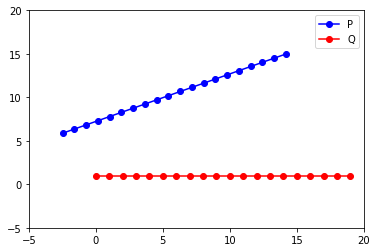

In [3]:
# initialize pertrubation rotation
angle = 0.5
R_true = np.mat([[cos(angle), -sin(angle)], 
                 [sin(angle),  cos(angle)]])
t_true = np.mat([[-2], [5]])

# generate data as a list of 2d points
num_points = 20
Q = np.mat(np.ones((2, num_points)))
Q[0, :] = range(0, num_points)
P = R_true * Q + t_true

plot_data(P, Q)
plt.show()

## Centered data: ##

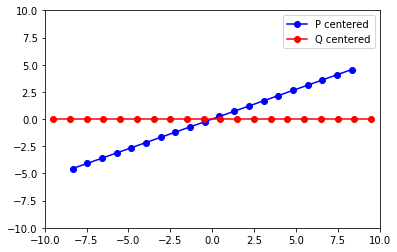

In [4]:
mu_P = P.mean(1)
mu_Q = Q.mean(1)
P_centered = P - mu_P
Q_centered = Q - mu_Q
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered',
               xlim=lim, ylim=lim)
plt.show()

## Correspondences: ##
We compute correspondences from $P$ to $Q$, i.e. for every $p_i$ we search the closest $q_j$ to it.

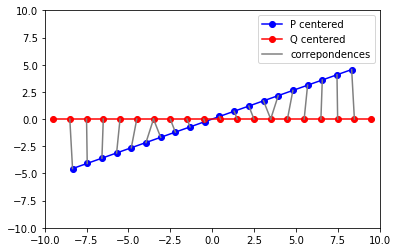

In [5]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

correspondences = get_correspondence_indices(P_centered, Q_centered)
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered',
               xlim=lim, ylim=lim)
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

## SVD - based ICP ##

#### Single iteration ####
In a single iteration we assume that the correspondences are known. We can compute the cross-correlation between the corresponding points. Let $C = \{\{i,j\}:p_i \leftrightarrow q_j\}$ be a set of all correspondences, also $|C| = N$. Then, the cross correlation $K$ is computed as:

\begin{eqnarray}
K &=& E [(q_i - \mu_Q)(p_i - \mu_P)^T] \\
&=& \frac{1}{N}\sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T} \\
&\sim& \sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T}
\end{eqnarray}

Each point has two dimentions, that is $p_i, q_j \in {\rm I\!R}$, thus cross correlation has the form of (we drop indices $i$ and $j$ for notation simplicity):

\begin{equation}
K =
  \begin{bmatrix}
    cov(p_x, q_x) & cov(p_x, q_y) \\
    cov(p_y, q_x) & cov(p_y, q_y)
  \end{bmatrix}
\end{equation}

Intuitevely, cross correlation tells us how a coordinate of point $q$ changes with the change of $p$ coorinate, i.e. $cov(p_x, q_x)$ tells us how the $x$ coordinate of $q$ will change with the change in $x$ coordinate of $p$ given that the points are corresponding. Ideal cross correlation matrix seems to be identity, i.e. we want the $x$ coordinates to be ideally correlated between the scans $P$ and $Q$, while there should be no correlation between the $x$ coorinate of points from $P$ to the $y$ coordinate of points in $Q$. 

**Example**: Given scans $P$ and $Q$ that match ideally and $\{p_i, q_j\} \in C$, we know that if we change the $x$ coordinate of $p_i$ we see exactly the same change in $x$ coordinate of $q_j$ while we observe no change in its $y$ coordinate. Therefore, the cross correlation matrix will be identity.

Knowing the cross correlation we can compute its SVD decomposition:

\begin{equation}
\mathrm{SVD}(K) = USV^T
\end{equation}

The SVD decomposition gives us how to rotate our data to align it with its prominent direction with $UV^T$ and how to scale it with its singular values $S$. Therefore:

\begin{eqnarray}
R &=& UV^T \\
t &=& \mu_Q - R \mu_P
\end{eqnarray}

#### Let's try this out: ####

## Compute cross covariance ##

In [6]:
def compute_cross_covariance(P, Q, correspondences):
    cov = np.mat([[0., 0.],
                  [0., 0.]])
    for i, j in correspondences:
        p_point = P[:, i]
        q_point = Q[:, j]
        cov += q_point * p_point.T
    return cov

cov = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[ 509.87546846  278.54623793]
 [   0.            0.        ]]


## Find $R$ and $t$ from SVD decomposition ##
Here we find SVD decomposition of the cross covariance matrix and apply the rotation to $Q$

In [7]:
U, S, V_T = np.linalg.svd(cov)
R_found = U * V_T
t_found = mu_Q - R_found * mu_P

## Apply correction to $P$ and visualize the result ##

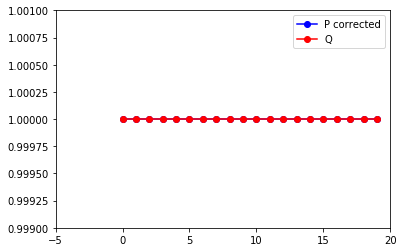

Squared diff: (P_corrected - Q) =  1.10337402719e-14


In [8]:
P_corrected = R_found * P + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q', ylim=[0.999, 1.001])
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

# Least-squares based ICP #
